# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Hyperparams

In [2]:
root = os.getcwd()
dataset =  os.path.join(root, 'dataset', 'yelp_review_polarity_csv')
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(dataset, 'train.csv') 
test_datapath = os.path.join(dataset, 'test.csv') 

processed_train_dataset = os.path.join(dataset, 'processed_train_datset.pickle')
processed_test_dataset = os.path.join(dataset, 'processed_test_dataset.pickle')
vocab_save_path = os.path.join(dataset, 'vocab.pickle')

model_save_root = os.path.join(root, 'output', 'transformer')

if os.path.exists(model_save_root) == False:
    os.makedirs(model_save_root)

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

BATCH_SIZE = 64

sample_size = 0.2

# Loading dataset

In [3]:
train_df = pd.read_csv(train_datapath, names = ["review","text"])
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
}
train_df['review'] = train_df['review'].map(label_map)
train_df.reset_index(inplace=True, drop = True)
print(train_df['review'].unique())
print(train_df['review'].value_counts())
train_df.head()

(112000, 2)
[0 1]
review
1    56018
0    55982
Name: count, dtype: int64


,review,text
0,0,I found this place on Google for Chinese Food ...
1,1,There is no surprise this hotel is #1. The pro...
2,1,"Its the closest grocery to my home, but I love..."
3,1,"Really great, speedy service. My pineapple fri..."
4,0,"Talk about annoying - the wait staff, especial..."


In [4]:
test_df = pd.read_csv(test_datapath, names = ["review","text"])
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
print(test_df.shape)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
test_df.head()

(38000, 2)
review
1    19000
0    19000
Name: count, dtype: int64


,review,text
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


# Cleaning

In [5]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [6]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df['lengths'] = eda_df['text'].apply(lambda s: len(s))
MAX_LENGTH = eda_df['lengths'].max()
print(MAX_LENGTH)
eda_df.head()

3729


,review,text,lengths
0,0,found place google chinese food delivery miles...,544
1,1,surprise hotel property amazing location perfe...,206
2,1,closest grocery home love many reasons tully i...,200
3,1,really great speedy service pineapple fried ri...,116
4,0,talk annoying wait staff especially service gi...,964


In [7]:
# Stats
eda_df.describe()


,review,lengths
count,112000.000000,112000.000000
mean,0.500161,437.379768
std,0.500002,399.384216
min,0.000000,0.000000
25%,0.000000,171.000000
50%,1.000000,319.000000
75%,1.000000,569.000000
max,1.000000,3729.000000


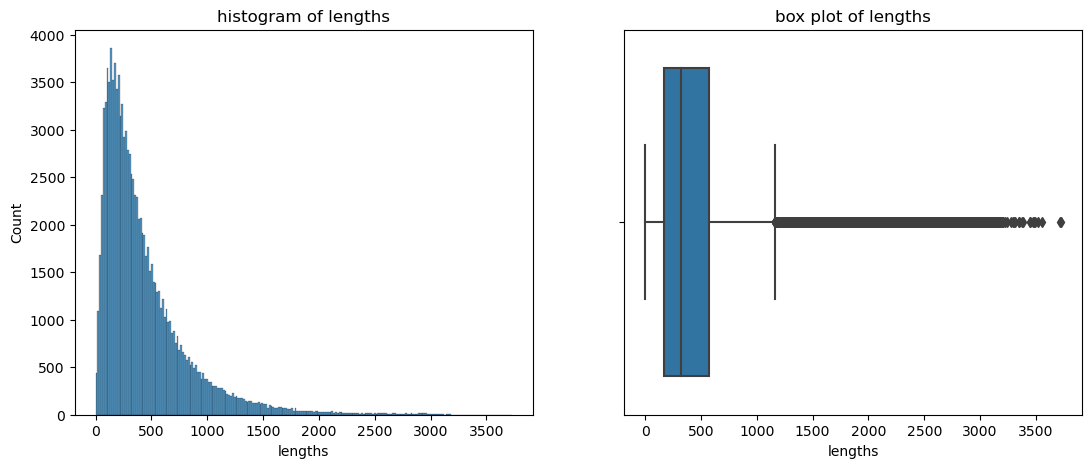

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(eda_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(eda_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

In [9]:
# # wordcloud of common words
# freq = collections.Counter()

# for row in eda_df.iterrows():
#     label, text = row[1]
#     freq.update(text.split())

# print('most frequent words')
# print(freq.most_common(10))


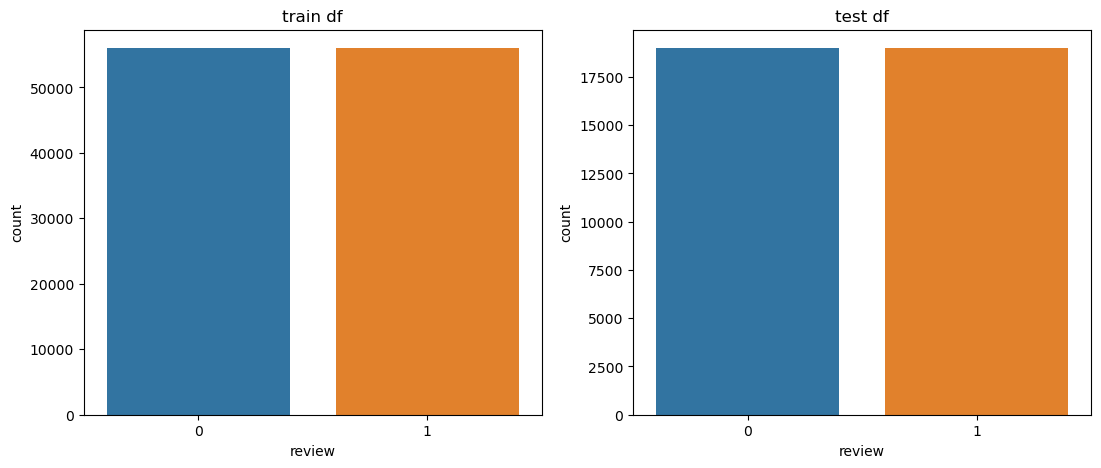

In [10]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()

# Prepare data

In [11]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 2000):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


def build_train_test_data_v2(feature_train, label_train, feature_test, label_test, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)
    test_tokens, test_lengths = build_array(feature_test)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens + test_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)
    test_ids, test_y, test_lengths = convert_to_ids_labels_lengths(test_tokens, label_test, test_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), \
            (test_tokens, test_ids, test_y, test_lengths),\
            vocab, pad_id

In [12]:
all_df = pd.concat([train_df, test_df])

X_array = all_df['text'].apply(lambda s: clean_text(s)).values
y_array = all_df['review'].values

# X_array_test = test_df['text'].apply(lambda s: clean_text(s)).values
# y_array_test = test_df['review'].values

(train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)
# test_ids = pad_sequence(test_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y values = ', set(train_y.tolist()) )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

# print('test')
# print('ids shape = ', test_ids.shape )
# print('y values = ', set(test_y.tolist()) )
# print('y shape = ', test_y.shape )
# print('lengths shape = ', test_lengths.shape)

100%|██████████| 150000/150000 [00:05<00:00, 29221.06it/s]


vocab len =  60999


100%|██████████| 150000/150000 [00:03<00:00, 38193.45it/s]


ids shape =  torch.Size([150000, 587])
y values =  {0, 1}
y shape =  torch.Size([150000])
lengths shape =  torch.Size([150000])


In [13]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=0
tokens=['found', 'place', 'google', 'chinese', 'food', 'delivery', 'miles', 'road', 'called', 'ordered', 'three', 'things', 'two', 'lunch', 'specials', 'bbq', 'spare', 'ribs', 'appetizer', 'told', 'would', 'admit', 'thirty', 'minutes', 'hour', 'goes', 'call', 'ask', 'food', 'lady', 'assured', 'driver', 'delivering', 'almost', 'two', 'hours', 'later', 'called', 'one', 'shown', 'argue', 'woman', 'cancel', 'order', 'refund', 'money', 'wanted', 'give', 'free', 'food', 'next', 'order', 'like', 'would', 'order', 'finally', 'agreed', 'refund', 'money', 'literally', 'thirty', 'seconds', 'hung', 'driver', 'arrived', 'told', 'cancelled', 'two', 'hours', 'late', 'leave', 'assured', 'food', 'hot', 'yeah', 'right', 'closed', 'door', 'heard', 'screaming', 'outside', 'house', 'phone', 'never', 'order', 'delivery']
length=86
ids=tensor([ 171,    3, 4198,  501,    2,  721, 1310, 1223,  137,   24,  263,  139,
          41,  103,  726,  447, 3437,  778,  504,   58,    5, 1492, 4445,   48,
       

# Model

In [14]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

        # self.P = self.P.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.device == self.P.device, 'in positional encoding, X should have the same device with P'
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens, 
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len).to(src.device)

        transformer_output = self.encoder(src, mask)

        # print('transformer output shape = ', transformer_output.shape)
        output = self.fc(transformer_output[:,-1]) 
        # print('fc output shape = ', output.shape)
        return output

In [15]:
input_size = 100 
num_class = 2
num_heads = 5
fc_hidden_size = 5
num_tokens = 1000
    
clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens)
clf.to(DEVICE)
# clf.convert_to_device(DEVICE)
X = torch.randint(0,1000,(10,5)).to(DEVICE)

y = clf(X, None)

# Dataset

In [16]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]


In [17]:
train_dataset = YelpReview(train_ids, train_y, train_lengths)
# test_dataset = YelpReview(test_ids, train_y, train_lengths)

print(train_dataset)

# Save the YelpDataset

with open(processed_train_dataset, 'wb') as file:
    pickle.dump(train_dataset, file)

# with open(processed_test_dataset, 'wb') as file:
#     pickle.dump(test_dataset, file)

with open(vocab_save_path, 'wb') as file:
    pickle.dump(vocab, file)


In [18]:
# Load dataset
with open(processed_train_dataset, 'rb') as file:
    train_dataset = pickle.load(file)

# with open(processed_test_dataset, 'rb') as file:
#     test_dataset = pickle.load(file)

with open(vocab_save_path, 'rb') as file:
    vocab = pickle.load(file)

print(train_dataset)
print(vocab)
print(len(vocab))

NUM_CLASSES = len(set(train_dataset.labels.tolist()))
print('num classes = ', NUM_CLASSES)

Vocab()
60999
num classes =  2


In [19]:
# test model running on dataloader

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
test_val_len = (len(train_dataset) - train_len)//2
train_dataset, val_dataset, test_dataset = random_split(train_dataset,[train_len, test_val_len, test_val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))
print('test dataset len = ', len(test_dataset))
print('test dataloader len = ', len(test_dataloader))

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


num class =  2
train dataset len =  120000
train dataloader len =  1875
val dataset len =  15000
val dataloader len =  235
test dataset len =  15000
test dataloader len =  235
id shape =  torch.Size([64, 587])
label shape =  torch.Size([64])
lengths shape =  torch.Size([64])


# Tune function

In [20]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        # prediction = model(ids, length)
        prediction = model(ids)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
        
def pickle_load(path):
    with open(path, 'wb') as file:
        obj = pickle.load(file)
    return obj

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model,train_dataloader, val_dataloader, test_dataloader,  
         optimizer, criterion, device, epochs = 10, label = 'baseline', history = None):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_score = -float("inf")

    save_path = os.path.join(model_save_root, label)
    if os.path.exists(save_path) == False:
        os.makedirs(save_path)

    if history == None:
        history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")
        pickle_dump(history, os.path.join(save_path, 'history.pickle'))
        torch.save(model, os.path.join(save_path, f"yelp.transformers.checkpoint.pt"))

        plot(history, save_path = os.path.join(save_path, 'plot.png'))

    if test_acc < best_score:
        best_score = test_loss
        torch.save(model, os.path.join(model_save_root, f"yelp.transformers.best.pt"))
    
    plot(history, save_path = os.path.join(save_path, 'plot.png'), show = True)
    return history

def plot(history, save_path = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],   label ='test accuracy',    x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],   label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.clf()

# Pretrained embedding

In [21]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

output dim =  2
The model has 19619186 trainable parameters


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]


epoch: 0
train_loss: 0.290, train_acc: 0.878
val_loss: 0.374, valid_acc: 0.890
test_loss: 0.386, test_acc: 0.889


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.95it/s]


epoch: 1
train_loss: 0.222, train_acc: 0.910
val_loss: 0.329, valid_acc: 0.904
test_loss: 0.312, test_acc: 0.907


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.96it/s]


epoch: 2
train_loss: 0.199, train_acc: 0.921
val_loss: 0.314, valid_acc: 0.911
test_loss: 0.302, test_acc: 0.913


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.95it/s]


epoch: 3
train_loss: 0.183, train_acc: 0.928
val_loss: 0.360, valid_acc: 0.911
test_loss: 0.353, test_acc: 0.911


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]


epoch: 4
train_loss: 0.170, train_acc: 0.933
val_loss: 0.387, valid_acc: 0.911
test_loss: 0.395, test_acc: 0.909


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.94it/s]


epoch: 5
train_loss: 0.159, train_acc: 0.938
val_loss: 0.349, valid_acc: 0.912
test_loss: 0.350, test_acc: 0.912


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.85it/s]


epoch: 6
train_loss: 0.153, train_acc: 0.941
val_loss: 0.445, valid_acc: 0.914
test_loss: 0.445, test_acc: 0.916


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.92it/s]


epoch: 7
train_loss: 0.144, train_acc: 0.945
val_loss: 0.373, valid_acc: 0.914
test_loss: 0.366, test_acc: 0.915


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]


epoch: 8
train_loss: 0.140, train_acc: 0.947
val_loss: 0.404, valid_acc: 0.911
test_loss: 0.410, test_acc: 0.911


evaluating...: 100%|██████████| 235/235 [00:11<00:00, 19.98it/s]


epoch: 9
train_loss: 0.134, train_acc: 0.949
val_loss: 0.462, valid_acc: 0.908
test_loss: 0.476, test_acc: 0.907


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

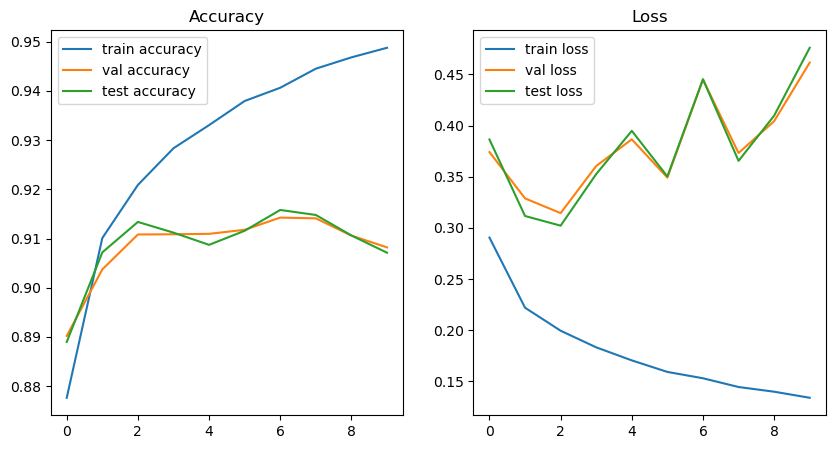

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [23]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 128,
    num_tokens = vocab_size,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model,  train_dataloader, val_dataloader, test_dataloader, 
               optimizer, criterion, epochs = 10, device = DEVICE)

plot(history)

In [ ]:
# #resume
# history = tune(model,  train_dataloader, val_dataloader, test_dataloader, 
#                optimizer, criterion, epochs = 5, device = DEVICE, history = history)

# Notes

test accuracy not improving. Perhaps the train vocab and test vocab is too different. Try merging train and test tokens. See what happens.